🔹 1. What is a “programmable metasurface”?

A metasurface is like an artificial surface made of many small “pixels” (we call them meta-atoms or unit cells).

Each pixel can change how it interacts with electromagnetic waves (like phase, amplitude, frequency).

If we make these pixels programmable (using electronics like diodes, varactors, MEMS, or FPGA control), we can dynamically change how waves are reflected, transmitted, or absorbed.

👉 Think of it like a digital mirror: instead of only showing your reflection, it can redirect, split, or change the color (frequency) of waves.

Here I am trying to build a programable platform to STMM. When considering more about meta surfaces (here you can find 

🔹 2. Static vs. Space-Time Programmable Surfaces

Static metasurface → fixed pattern, can bend beams or focus, but once built, it doesn’t change.

Programmable (space-only) → you can electronically change the surface at different positions. For example, change the phase at pixel 1 vs pixel 2 to steer a beam.

Space-time programmable → you also change things with time. For example:

At 1 ns the surface looks one way,

At 2 ns it changes,

At 3 ns it changes again. This adds a time dimension, letting you do crazy things like frequency shifting or non-reciprocal wave control.

🔹 3. Why code a simulation first?

Before building actual hardware, I made numerical simulations of how waves interact with programmable metasurfaces.

I defined a metasurface modulation pattern (how the surface changes with space and time).

I multiplied them → meaning the surface applies its modulation to the wave.

Then I visualized what happens.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Here I have simulated incident wave and modulated wave 

E_inc = np.cos(k0 * X - omega0 * T)
This represents a plane wave traveling across your surface.
It’s your input wave — before interacting with the metasurface.

The formula cos(kx - ωt) means:

The wave moves forward in the x-direction.

It oscillates in time and space (like ripples in a pond).

**
modulation_frequency = 1e9   # 1 GHz modulation
modulation_wavenumber = k0/2 # half of incident wavevector
modulation = np.cos(modulation_wavenumber * X - 2*np.pi*modulation_frequency * T)
**

Here’s where the programmable metasurface comes in:

You define a modulation pattern — a second wave that represents how the metasurface is varying in space and time.

The term modulation_wavenumber * X → the surface’s spatial variation (like phase gradient across its width).

The term 2π * modulation_frequency * T → how the surface changes in time (dynamic modulation).

📡 Physically, this could correspond to:

Applying electronic bias voltages to each meta-atom,

Making their reflection phase oscillate in time,

Effectively shifting or mixing frequencies (useful for communication).


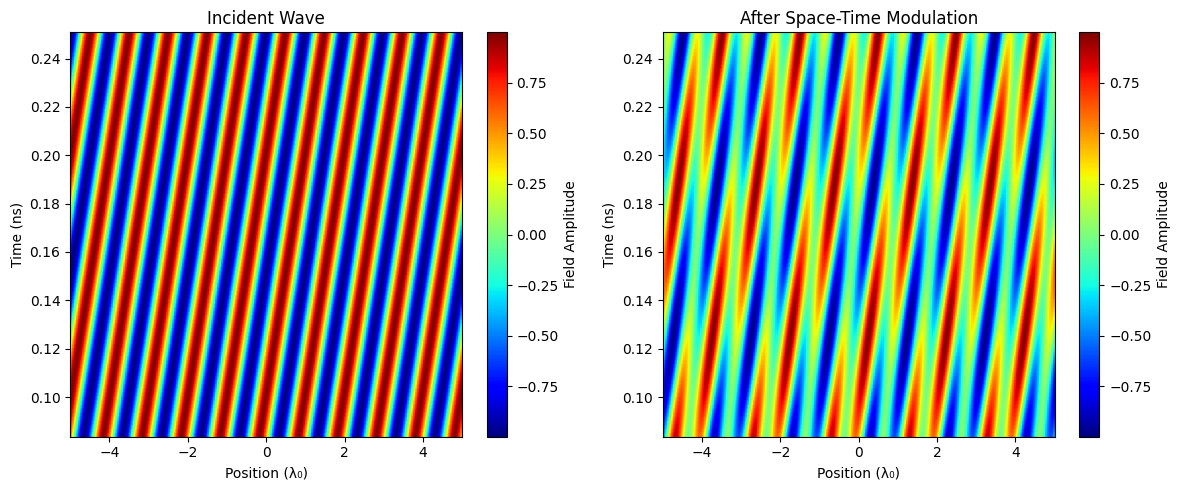

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ===========================
# Parameters
# ===========================
c = 3e8                     # Speed of light (m/s)
f0 = 10e9                   # Carrier frequency (10 GHz)
lambda0 = c / f0            # Wavelength
k0 = 2 * np.pi / lambda0    # Wave number
omega0 = 2 * np.pi * f0     # Angular frequency

# ===========================
# Space-time grid
# ===========================
Nx, Nt = 200, 300
x = np.linspace(-5*lambda0, 5*lambda0, Nx)   # Position axis
t = np.linspace(0, 5/f0, Nt)                 # Time axis
X, T = np.meshgrid(x, t)

# ===========================
# Incident wave (plane wave)
# ===========================
E_inc = np.cos(k0 * X - omega0 * T)

# ===========================
# Programmable metasurface modulation
# ===========================
modulation_frequency = 1e9    # 1 GHz modulation
modulation_wavenumber = k0/2  # Half of incident wavevector
modulation = np.cos(modulation_wavenumber * X - 2*np.pi*modulation_frequency * T)

# ===========================
# Output field after metasurface
# ===========================
E_out = E_inc * modulation

# ===========================
# Plot both waves side by side
# ===========================
plt.figure(figsize=(12, 5))

# Subplot 1: Incident wave
plt.subplot(1, 2, 1)
plt.imshow(E_inc[50:150, :], aspect='auto',
           extent=[x[0]/lambda0, x[-1]/lambda0, t[50]*1e9, t[150]*1e9],
           cmap='jet', origin='lower')
plt.colorbar(label='Field Amplitude')
plt.title('Incident Wave')
plt.xlabel('Position (λ₀)')
plt.ylabel('Time (ns)')

# Subplot 2: Modulated (Output) wave
plt.subplot(1, 2, 2)
plt.imshow(E_out[50:150, :], aspect='auto',
           extent=[x[0]/lambda0, x[-1]/lambda0, t[50]*1e9, t[150]*1e9],
           cmap='jet', origin='lower')
plt.colorbar(label='Field Amplitude')
plt.title('After Space-Time Modulation')
plt.xlabel('Position (λ₀)')
plt.ylabel('Time (ns)')

plt.tight_layout()
plt.show()


Now I am turning your metasurface simulation into a programmable pixel array, similar to what real reconfigurable metasurfaces use.

In a real programmable metasurface:

The surface is divided into small unit cells (pixels).

Each cell can be programmed to change its phase or amplitude response.

It can be digitally controlled these cells (like a binary or multi-state pattern).

I have simulate this behavior:

Divided the space (x) into cells.

Gave each cells a random or designed phase state.

Apply that phase to modulate the incident wave.



Look at this part of your simulation again:

phase_states = np.random.choice([0, np.pi/2, np.pi, 3*np.pi/2], num_cells)


Each metasurface cell is given one of four discrete phase states — just like real programmable metasurfaces, where each element can be set to one of a few digital phase codes (e.g. 2-bit = 4 levels).

That’s literally a software-controlled configuration.

If you later replace that np.random.choice(...) with a control matrix, you can design exactly what the metasurface should do:

Focus a beam,

Steer it to a specific angle,

Or modulate it in time.

So this line represents the “programming” of your metasurface.

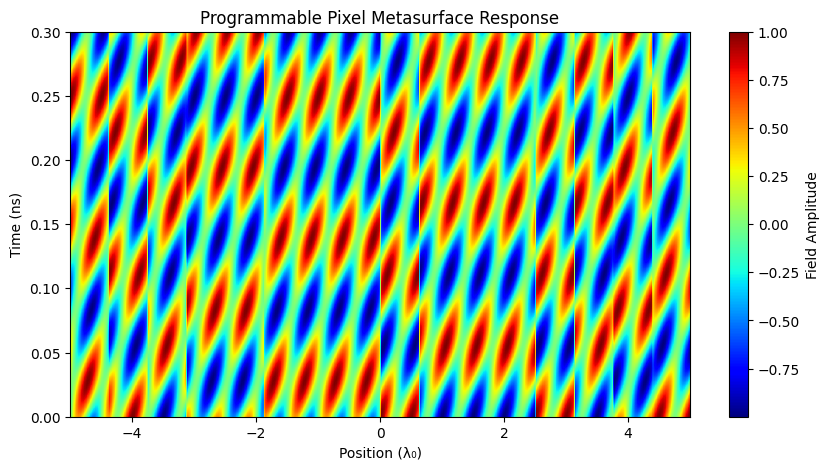

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ============================
# 1. Basic physical parameters
# ============================
c = 3e8               # speed of light
f0 = 10e9             # carrier frequency (10 GHz)
lambda0 = c / f0
k0 = 2 * np.pi / lambda0
omega0 = 2 * np.pi * f0

# ============================
# 2. Space and time grid
# ============================
Nx, Nt = 400, 300
x = np.linspace(-5*lambda0, 5*lambda0, Nx)
t = np.linspace(0, 3/f0, Nt)
X, T = np.meshgrid(x, t)

# ============================
# 3. Incident wave
# ============================
E_inc = np.cos(k0 * X - omega0 * T)

# ============================
# 4. Programmable metasurface (discrete pixels)
# ============================
num_cells = 16                        # number of programmable cells
cell_size = Nx // num_cells           # points per cell
phase_states = np.random.choice([0, np.pi/2, np.pi, 3*np.pi/2], num_cells)  # random phase states

# build modulation pattern (each cell has its own phase)
modulation = np.zeros_like(X)
for i, phi in enumerate(phase_states):
    start = i * cell_size
    end = (i + 1) * cell_size
    modulation[:, start:end] = np.cos(k0 * X[:, start:end] - 2*np.pi*1e9*T[:, start:end] + phi)

# ============================
# 5. Output field (after metasurface)
# ============================
E_out = E_inc * modulation

# ============================
# 6. Visualization
# ============================
plt.figure(figsize=(10,5))
plt.imshow(E_out, extent=[x[0]/lambda0, x[-1]/lambda0, t[0]*1e9, t[-1]*1e9],
           aspect='auto', cmap='jet', origin='lower')
plt.colorbar(label='Field Amplitude')
plt.xlabel('Position (λ₀)')
plt.ylabel('Time (ns)')
plt.title('Programmable Pixel Metasurface Response')
plt.show()


Example 1: Beam Focusing Metasurface

🎯 Goal: Focus a plane wave to a specific point in space — similar to how a lens concentrates light.

The Core Physics of Beam Focusing
1. What Focusing Means
When a plane wave hits a focusing metasurface, the surface transforms it from parallel wavefronts into converging spherical wavefronts that meet at a focal point. Think of it like transforming straight water ripples into circular ones that converge to a single point.
2. The Phase Profile Mathematics
For focusing at distance f from the surface, each point on the metasurface must impose a phase shift:
φ(x, y) = -k₀ × √(x² + y² + f²)
This compensates for the different path lengths from each point to the focus. Points farther from center need more phase delay.
3. Physical Implementation
In a real metasurface, you achieve this phase profile by:

Geometric variations: Different shaped meta-atoms at each position
Material variations: Different dielectric constants
Active control: Varactors or PIN diodes that tune the phase electronically

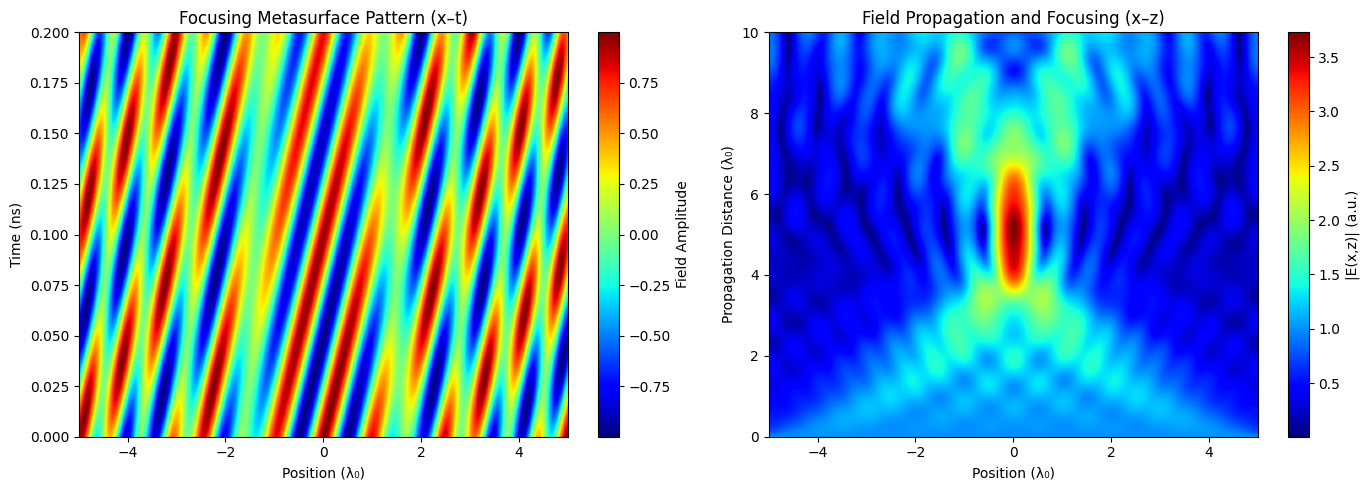

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. Physical Parameters
# =========================
c = 3e8
f0 = 10e9
lambda0 = c / f0
k0 = 2 * np.pi / lambda0
omega0 = 2 * np.pi * f0

# =========================
# 2. Space-Time Grid
# =========================
Nx, Nt = 400, 300
x = np.linspace(-5*lambda0, 5*lambda0, Nx)
t = np.linspace(0, 2/f0, Nt)
X, T = np.meshgrid(x, t)

# =========================
# 3. Incident Wave
# =========================
E_inc = np.cos(k0 * X - omega0 * T)

# =========================
# 4. Focusing Metasurface Pattern (time-varying modulation)
# =========================
focal_distance = 5 * lambda0
phase_profile = -k0 * np.sqrt(x**2 + focal_distance**2)# by the theory of φ(x, y) = -k₀ × √(x² + y² + f²) 
modulation = np.cos(phase_profile - 2*np.pi*0.5e9*T)  # 0.5 GHz modulation

E_out = E_inc * modulation

# =========================
# 5. Angular Spectrum Propagation (x–z field)
# =========================
dx = x[1] - x[0]
kx = 2 * np.pi * np.fft.fftfreq(Nx, d=dx)
kz = np.sqrt(k0**2 - kx**2 + 0j)

Nz = 300
z = np.linspace(0, 10*lambda0, Nz)

E_surface = np.exp(1j * phase_profile)
E_kx = np.fft.fft(E_surface)
E_z = np.zeros((Nz, Nx), dtype=complex)

for i, zi in enumerate(z):
    H = np.exp(1j * kz * zi)
    E_z[i, :] = np.fft.ifft(E_kx * H)

E_mag = np.abs(E_z)

# =========================
# 6. Visualization
# =========================
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# (a) Time-domain metasurface field pattern
im1 = axs[0].imshow(E_out, extent=[x[0]/lambda0, x[-1]/lambda0, t[0]*1e9, t[-1]*1e9],
                    aspect='auto', cmap='jet', origin='lower')
axs[0].set_title('Focusing Metasurface Pattern (x–t)')
axs[0].set_xlabel('Position (λ₀)')
axs[0].set_ylabel('Time (ns)')
fig.colorbar(im1, ax=axs[0], label='Field Amplitude')

# (b) Propagation field map
im2 = axs[1].imshow(E_mag, extent=[x[0]/lambda0, x[-1]/lambda0, z[0]/lambda0, z[-1]/lambda0],
                    aspect='auto', cmap='jet', origin='lower')
axs[1].set_title('Field Propagation and Focusing (x–z)')
axs[1].set_xlabel('Position (λ₀)')
axs[1].set_ylabel('Propagation Distance (λ₀)')
fig.colorbar(im2, ax=axs[1], label='|E(x,z)| (a.u.)')

plt.tight_layout()
plt.show()
